# Names (Enter your names below)
**Your Name and JHED:** Ryan Nguyen (rnguye14)

**Partner's Name and JHED (If applicable):**  Manny Etoh (ietoh4)

# Lab 2: U-Net Nuclei Segmentation [100 points total]
By **Molly Li** and **Kwame Kutten**

Image segmentaion involves dividing an image into **multiple regions**, each of which corresponds to a meaningful object or part of the image. For example one might want to divide an image into a forground regions of interest and background. In this lab we will train a **UNet** to segment nuclei in histopathological images.  These types of images can be used to are often used to diagnose cancer since nuclei size and shape are affected by disease. Most of the nuclei segmentation pipeline is **provided**. Modification of the provided functions and classes are **not necessary**, but feel free to do so if you want to attempt improving the performance.  
### Import
We start out by importing the necessary python modules

In [22]:
## Standard Library
import os

## External Libraries
try:
    import torch, torchvision, skimage
except:
    # Install packages if not available
    !conda install -y -c pytorch pytorch
    !conda install -y -c pytorch torchvision
    !conda install -y -c anaconda scikit-image
    import torch, torchvision, skimage

import numpy as np
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

### U-Net model
In this lab, we are going to use **U-Net** ([Ronneberger *et al* 2015](https://arxiv.org/abs/1505.04597)), a deep learning convolutional neural network (CNN) architecture designed for biomedical image segmentation.


In [23]:
# U-net class
class UNet(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNet, self).__init__()
    self.encoder1 = self.conv_block(in_channels, 32)
    self.encoder2 = self.conv_block(32, 64)
    self.encoder3 = self.conv_block(64, 128)
    self.encoder4 = self.conv_block(128, 256)

    # Expanding path
    self.decoder3 = self.conv_block(256, 128)
    self.decoder2 = self.conv_block(128, 64)
    self.decoder1 = self.conv_block(64, 32)

    self.upsample3 = self.upsample(256, 128)
    self.upsample2 = self.upsample(128, 64)
    self.upsample1 = self.upsample(64 , 32)

    # Output layer
    self.output = nn.Conv2d(32, out_channels, kernel_size=1)
    self.maxpool = nn.MaxPool2d(2)
    self.activation = nn.Sigmoid()


  def conv_block(self, in_channels, out_channels):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels,out_channels, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True) )
    return block

  def upsample(self, in_, out):
    return nn.Sequential(nn.ConvTranspose2d(in_, out, kernel_size=2, stride=2), nn.ReLU())

  def forward(self, x):
    encoder1_out = self.encoder1(x)
    encoder2_out = self.encoder2(self.maxpool(encoder1_out))
    encoder3_out = self.encoder3(self.maxpool(encoder2_out))
    encoder4_out = self.encoder4(self.maxpool(encoder3_out))

    # Expanding path
    decode3_out = self.decoder3(torch.cat((self.upsample3(encoder4_out), encoder3_out), 1))
    decode2_out = self.decoder2(torch.cat((self.upsample2(decode3_out), encoder2_out), 1))
    decode1_out = self.decoder1(torch.cat((self.upsample1(decode2_out), encoder1_out), 1))

    # Output
    output = self.activation(self.output(decode1_out))

    return output


### Load Data
Here we load the dataset which comes from [Mahbod *et al* 2021](https://doi.org/10.1016/j.compbiomed.2021.104349). The training dataset contains **24** H&E stained histological images and corresponding manually segmented nuclei as masks.   It has also has an addional  **6** image-mask pairs testing.


In [24]:
try:
    ## Mount Google Drive if using Google Colab
    from google.colab import drive
    drive.mount('/content/gdrive/')
    data_dir = "gdrive/MyDrive/Nuclei128x128"
except:
    # Otherwise read from disk if using Anaconda
    data_dir = "./Nuclei128x128"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [25]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

class SegImageDataset(Dataset):
    def __init__(self, data_dir, type_of_operation='train', transform=None):
        self.data_dir = data_dir
        self.type_of_operation = type_of_operation
        self.transform = transform
        self.image_dir = os.path.join(data_dir, type_of_operation, 'image')
        self.mask_dir = os.path.join(data_dir, type_of_operation, 'mask')
        self.images = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_name)
        mask = Image.open(mask_name)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

train_dataset = SegImageDataset(data_dir=data_dir, type_of_operation='train', transform=transforms.ToTensor())
test_dataset = SegImageDataset(data_dir=data_dir, type_of_operation='test', transform=transforms.ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=5,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Task 1: Display training data [15 points]

Use `displayImg` to **show three images** from the training dataset and their corresponding segmentation masks [5 points each]

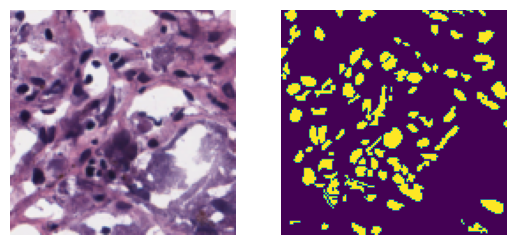

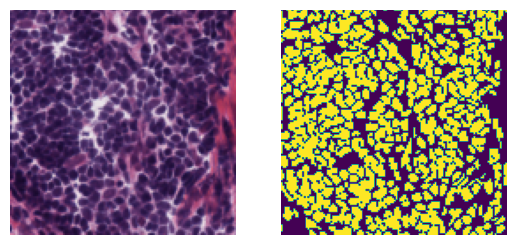

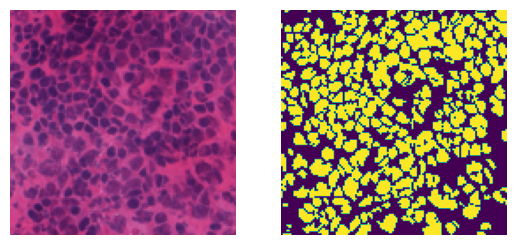

In [26]:

def displayImg(img):
  # Displays image stored in tensor
  if img.shape[0] == 3: # If color image rearrange dimensions to be (height, width, channels)
    plt.imshow(img.numpy().transpose(1,2,0))
  else:
    plt.imshow(img.numpy().squeeze())
  plt.axis("off") # Turn off axis labels and ticks

"""
Write your code here
"""
for i in range(3):
  img, mask = train_dataset[i]
  plt.figure()
  plt.subplot(1, 2, 1)
  displayImg(img)
  plt.subplot(1, 2, 2)
  displayImg(mask)

## Task 2: Dice score and loss [25 points]

The [**Dice score**](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) is used to assess how well the predicted segmentation $\hat{y}$ matches the actual segmentation $y$.  Intuitivly measures the *amount of overlap* between the predicted and actual segmentations.  Mathematically it is described as
$$
D(\hat{y},y) = \frac{2 | \hat{y} \cdot y |+s}{ |\hat{y} \cdot \hat{y}| + |y\cdot y| +s}
$$
Where $\cdot$ denotes dot product $s$ is an optional smooth parameter to avoid zero division errors.  The dice score is always in a range from 0.0 to 1.0 where 0.0 indicates no overlap and 1.0 indicates perfect overlap.  
 * Complete the `dice_score` function below [5 points]



In [27]:
def dice_score(y_hat, y, smooth=0):
    # Flatten to vectors
    y_hat = y_hat.view(-1)
    y = y.view(-1)
    numerator = 2 * abs(torch.dot(y_hat, y)) + smooth
    denominator = abs(torch.dot(y_hat, y_hat)) + abs(torch.dot(y, y)) + smooth
    return numerator / denominator

Validate your `dice_score` functon.
* Create two 20x20 torch tensors. [5 points]
 * `v` in which $v_{ij}$ = 1 when $i,j \in [0,10)$ and  $S_{ij} = 0$ otherwise.
 * `w` in which $w_{ij}$ = 1 when $i,j \in [5,15)$ and  $S_{ij} = 0$ otherwise.
* Use `displayImg` to show both tensors.   Notice how there 25% overlap between `v` and `w` [5 points]
* Use `dice_score` to show that $D(v,v) = 1$ and $D(v,w) = 0.25$ [5 points]


In [28]:
v = torch.zeros((20,20))
v[0:10, 0:10] = 1
w = torch.zeros((20,20))
w[5:15, 5:15] = 1

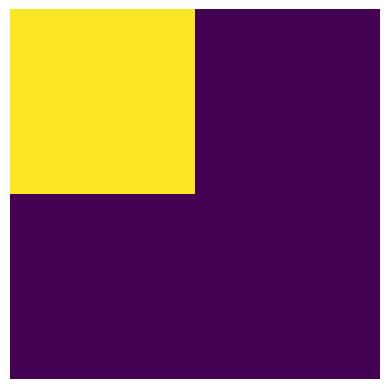

In [29]:
displayImg(v)


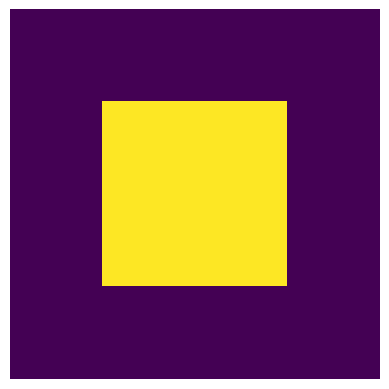

In [30]:
displayImg(w)

In [31]:
print(f'The Dice score for v with v is {dice_score(v,v)} while the Dice score for v with w is {dice_score(v,w)}')

The Dice score for v with v is 1.0 while the Dice score for v with w is 0.25


Our optimizer will seek to minimimize a loss function.  Therefore we would like it to minimial when there the dice score is maximized.  Thus our **Dice loss** is defined as
$$
L(\hat{y}, y) = 1 - D(\hat{y}, y)
$$
* Implement `forward` method in the `dice_loss` class below. [5 points]

In [32]:
class DICELoss(nn.Module):
    def __init__(self):
      super().__init__()
      self.smooth = 1e-6

    def forward(self, y_hat, y):
        loss = 1 - dice_score(y_hat, y, self.smooth)
        return loss


## Task 3: Train model [20 points]
Update code below to train your U-Net.
* For each batch from `train_dataloader`
 * Use model to predict segmentaion
 * Calculate the loss between prediction and actual segmentation
 * Add loss to `total_loss`
 * Back-propagate loss using `.backward()` method
 * Update optimizer using `.step()` method

Note that you may need to adjust hyperparameters such as `learning_rate` and `num_epocs` to get good results.

In [33]:
learning_rate = 0.01
num_epochs = 200
streak = 0
min_loss = np.inf

model = UNet(3, 1)
lossFunction = DICELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

loss_list = []
for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")

    total_loss = 0.0
    model.train()

    for img, mask in train_dataloader:
      pred = model.forward(img)
      loss = lossFunction.forward(pred, mask)
      total_loss += loss
      loss.backward()
      optimizer.step()

    loss_list.append(total_loss)
    print("loss\n", total_loss)

    if total_loss < min_loss:
      min_loss = total_loss
      streak = 0
    else:
      streak += 1
      if streak >= 10:
        print("Stopping early since loss hasn't changed in 10 epoches")
        break



EPOCH 1 of 200

loss
 tensor(2.2687, grad_fn=<AddBackward0>)

EPOCH 2 of 200

loss
 tensor(2.2741, grad_fn=<AddBackward0>)

EPOCH 3 of 200

loss
 tensor(2.2646, grad_fn=<AddBackward0>)

EPOCH 4 of 200

loss
 tensor(2.2551, grad_fn=<AddBackward0>)

EPOCH 5 of 200

loss
 tensor(2.2264, grad_fn=<AddBackward0>)

EPOCH 6 of 200

loss
 tensor(2.2301, grad_fn=<AddBackward0>)

EPOCH 7 of 200

loss
 tensor(2.2053, grad_fn=<AddBackward0>)

EPOCH 8 of 200

loss
 tensor(2.2172, grad_fn=<AddBackward0>)

EPOCH 9 of 200

loss
 tensor(2.1797, grad_fn=<AddBackward0>)

EPOCH 10 of 200

loss
 tensor(2.1554, grad_fn=<AddBackward0>)

EPOCH 11 of 200

loss
 tensor(2.0944, grad_fn=<AddBackward0>)

EPOCH 12 of 200

loss
 tensor(2.0455, grad_fn=<AddBackward0>)

EPOCH 13 of 200

loss
 tensor(1.9169, grad_fn=<AddBackward0>)

EPOCH 14 of 200

loss
 tensor(1.7702, grad_fn=<AddBackward0>)

EPOCH 15 of 200

loss
 tensor(1.6318, grad_fn=<AddBackward0>)

EPOCH 16 of 200

loss
 tensor(1.4558, grad_fn=<AddBackward0>)



## Task 4: Evaluate model [20 points]
Evaluate your model on training dataset
* Plotting total **loss** at each **epoch**. Your loss should have a overall decresing trend, but it might not be perfectly smooth. [10 points]
* Report the mean dice score across all 24 training images [10 points]

Text(0, 0.5, 'Total Loss')

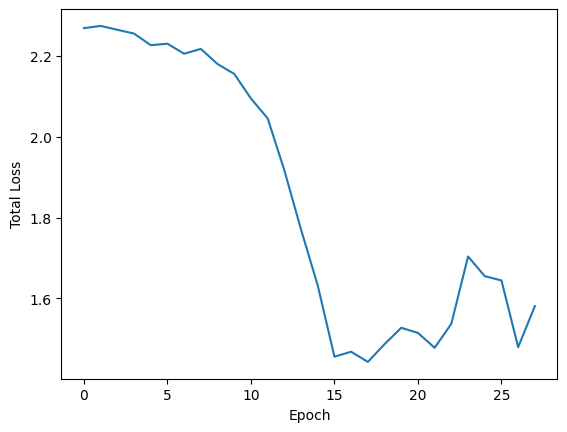

In [34]:
loss_array = np.asarray([l.detach().numpy() for l in loss_list])
plt.plot(loss_array)
plt.xlabel("Epoch")
plt.ylabel("Total Loss")

In [35]:
dice_array = (-1 * (loss_array - 24)) / 24
mean_ds_train = np.mean(dice_array)
print(f'The mean dice score across all 24 training images is {mean_ds_train:.02f}')

The mean dice score across all 24 training images is 0.92


## Task 5: Test model [20 points]
For each of the 6 images in the test dataset
- Use `displayImg` to show the image, actual segmentaion, predicted segmentation.  You might find `plt.subplot` helpful here. [2 points each]
- Use `dice_score` to display the Dice score comparing prediction and actual segmentaion [1 point each]

Then report the mean dice score across all 6 test images [2 points]

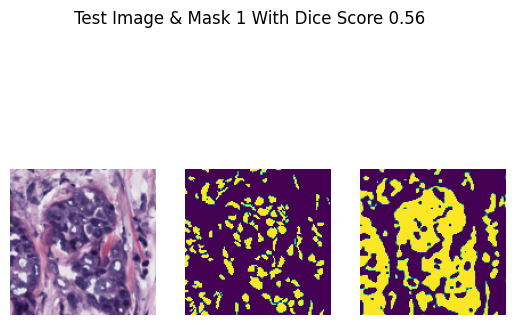

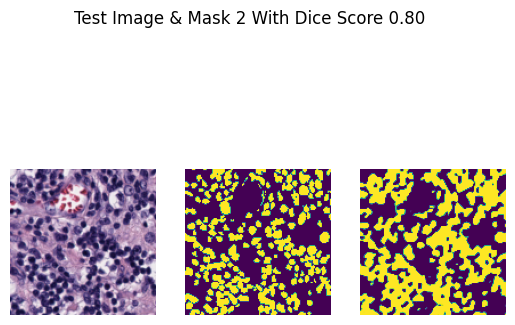

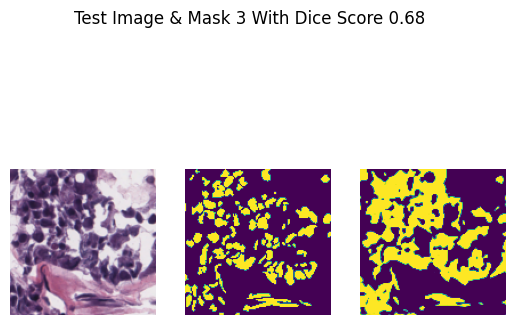

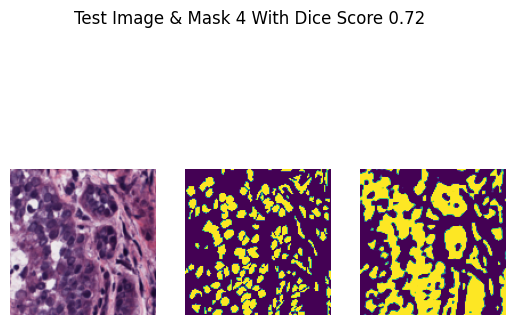

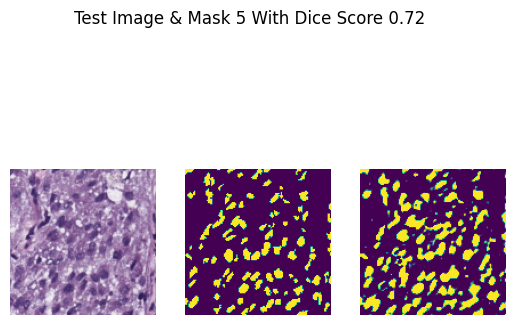

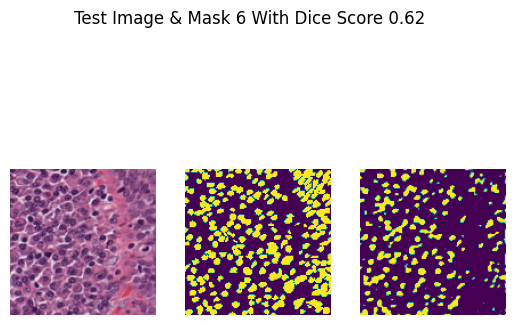

In [36]:
ds_list = []
for i, (img, mask) in enumerate(test_dataloader):
  pred = model.forward(img).detach()
  plt.figure()
  plt.subplot(1,3,1)
  displayImg(torch.squeeze(img))
  plt.subplot(1,3,2)
  displayImg(mask)
  plt.subplot(1,3,3)
  displayImg(pred)
  ds = dice_score(pred, mask)
  ds_list.append(ds)
  plt.suptitle(f"Test Image & Mask {i + 1} With Dice Score {ds:.02f}")

In [37]:
mean_ds_test = np.mean(np.asarray(ds_list))
print(f'The mean Dice score across all 6 test images is {mean_ds_test:.02f}')

The mean Dice score across all 6 test images is 0.68
